<a href="https://colab.research.google.com/github/arka57/RNN/blob/main/LSTM_MNIST_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Task: Classification on MNIST dataset where digits photos will be classified into which digit it is. LSTM will be applied for performing the task**

In [ ]:
# Imports
import torch
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For a nice progress bar!

import matplotlib.pyplot as plt
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Hyperparameters
input_size = 28
hidden_size = 256
num_layers = 1
output_size = 10
sequence_length = 28
learning_rate = 0.005
batch_size = 64
num_epochs = 2

In [ ]:
# Load Data
train_dataset = datasets.MNIST(
    root="dataset/", train=True, transform=transforms.ToTensor(), download=True
)
test_dataset = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

#Visualizing Data

In [ ]:
print(train_dataset.data[0])

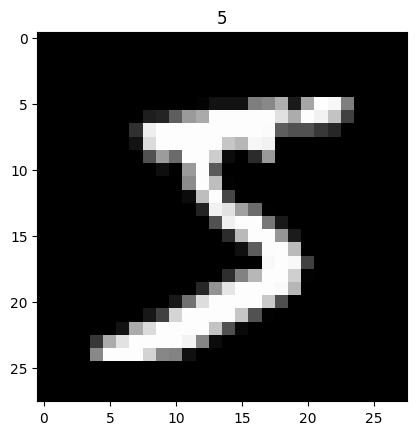

In [ ]:
plt.imshow(train_dataset.data[0], cmap='gray')
plt.title('%i' % train_dataset.targets[0])
plt.show()

In [ ]:
print(train_dataset.targets[0])

tensor(5)


#Model

In [ ]:
class LSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,num_layers):
        super(LSTM,self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.lstm=nn.LSTM(input_size,hidden_size,batch_first=True)
        self.fc=nn.Linear(hidden_size,output_size)

    def forward(self,x):

        #initialising hidden state and cell state
        h0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
        c0=torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)

        out,_=self.lstm(x,(h0,c0))

        #taking output of the last timestamp
        out=self.fc(out[:,-1,:])
        return out

#Initialize network

In [ ]:
model=LSTM(input_size,hidden_size,output_size,num_layers).to(device)

#Loss and optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)

# Evaluation

In [ ]:
def evaluation(dataloader):
    total=0
    correct=0
    for i in dataloader:
        data,targets=i
        data = data.to(device=device).squeeze(1)
        targets = targets.to(device=device)
        output=model(data)
        _,pred=torch.max(output,1)
        total+=targets.size(0)
        correct+=(pred==targets).sum().item()
    return (correct/total)*100

# Training Network

In [ ]:
loss_epoch=[]

100%|██████████| 938/938 [00:10<00:00, 87.52it/s]


Epoch 0/2 ,Training accuracy 98.55,Test Accuracy 98.45


100%|██████████| 938/938 [00:11<00:00, 82.60it/s]


Epoch 1/2 ,Training accuracy 98.79,Test Accuracy 98.17


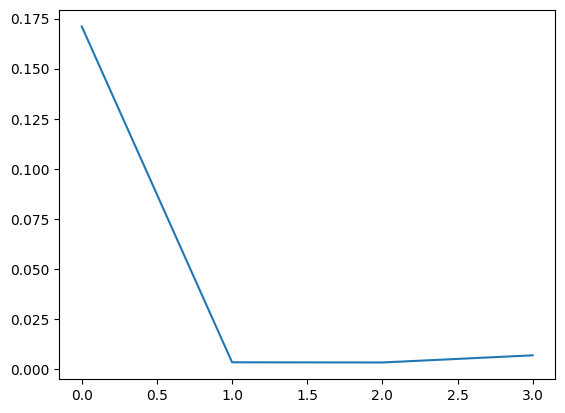

In [ ]:
for epoch in range(num_epochs):
    for batch_id,(data,targets) in enumerate(tqdm(train_loader)):
        data = data.to(device=device).squeeze(1) # dataloader has Nx1x28x28 shape. LSTM wants Nx28x28 shape so we squeeze dimension 1
        targets = targets.to(device=device)

        output=model(data)
        loss=criterion(output,targets)

        opt.zero_grad()
        loss.backward()
        opt.step()
    loss_epoch.append(loss.item())
    print('Epoch %d/%d ,Training accuracy %0.2f,Test Accuracy %0.2f' %(epoch,num_epochs,evaluation(train_loader),evaluation(test_loader)))
plt.plot(loss_epoch)
plt.show()